<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fraud detection withh autoencoders
#   https://www.kaggle.com/code/hone5com/fraud-detection-with-variational-autoencoder
# https://www.tensorflow.org/tutorials/generative/cvae

# https://www.kaggle.com/code/charel/learn-by-example-variational-autoencoder
# https://www.jeremyjordan.me/variational-autoencoders/
# https://www.jeremyjordan.me/autoencoders/

# The promise of variational autoencoders
I am fascinated by the possibilities of variational autoencoders. Why? Because it has the capability to abstract a compressed representation of the data, without the need to label the data. Moreover, the variational autoencoder estimates the latent/hidden states according to the leading neuroscientific approach that might explain the structure and function of the brain, starting from the very fact that we exist!

This capability to get a compressed representation out of the original input data has the potential to abstract meaning out of data. Something that we, humans, do every minute of the day. The higher brain functions translate lower-level sensory information (e.g. pixel blob on the retina) to meaning (e.g. it is an apple) and link all the various information around that meaning together. (e.g. I know how it tastes, or if we were talking about stock prices I know it is the company that makes iPhones). Something that we have not been able to replicate in artificial neural networks. Abstracting meaning or knowledge representation is still one of the key challenges in the field of artificial intelligence research. The variational autoencoder approach looks very promising.

So, if you are interested please keep on reading and upvote top right, leave a comment or contact me directly.

For a quick introduction of autoencoders please watch this [video](https://www.youtube.com/watch?v=9zKuYvjFFS8&t=3s), it gives you a good overview, and it inspired me to reproduce the steps taken in this notebook.

# Table of Contents
1. [Autoencoder](#sec1)
2. [Variational autoencoder](#sec2)
3. [Disentangled Variational autoencoder](#sec3)
4. [Appendix - The Free Energy bounds the surprise in the sensory observations](#secA)

I would like to acknowledge these sources that helped me better understand the (variational) autoencoder, learning by example:  
https://blog.keras.io/building-autoencoders-in-keras.html  
https://www.slideshare.net/JonathanRonen/jonathan-ronen-variational-autoencoders-tutorial  
https://nbviewer.jupyter.org/gist/jonathanronen/69902c1a97149ab4aae42e099d1d1367  
https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder/  

<a id='sec1'></a>
# Autoencoder
An autoencoder consists out of 2 parts: encoder (reducing dimensionality to a compressed representation) + decoder (reconstructing the original input from the compressed representation). It is a neural network the can learn without the need for label annotation because the difference between the original input and reconstructed output is used as the loss function to optimize the network. Reducing dimensionality is enforced by a small or bottleneck in the inner part of the auto-encoder, the so-called latent space.

For the first autoencoder example, I will use the well-known MNIST dataset. The 28*28 images are compressed to a 2 neuron latent representation, and I am especially interested in how this inner representation looks like.


![](https://i.imgur.com/M8yBf54.jpg)





In [1]:
# Import all we need

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
from ipywidgets import interact
from tensorflow.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
print ('import completed')


import completed


11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


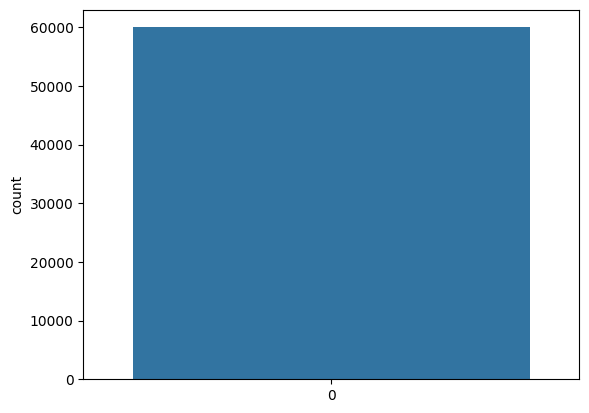

In [2]:
# Load the data, MNIST is nowadays incorporated in Keras/Tensorflow, so rather easy to use

(x_train, x_train_label), (x_test, x_test_label) = mnist.load_data()
#(x_train, x_train_label), (x_test, x_test_label) = fashion_mnist.load_data() # In case you want to try fashion mnist

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Show the dimensions
print(x_train.shape)
print(x_test.shape)

# verify the labels are distributed evenly
g = sns.countplot(x_train_label)

In [4]:
x_train_label

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## The autoencoder model

In this example, I use for the encoder and decoder both plain dense neural networks, both 2 layers. You could also use deeper structures or RNN/LSTM or convolutional layers. The code is parameterized, so you can experiment for yourself on the dimension of e.g. the latent space. Note that the encoder and decoder don't have to have the exact same network structure.  
The autoencoder is defined as one model, plus separately the encoder model and decoder model, referencing the autoencoder layers (the 3 models share their weights), in order to inspect the inner representation (this part can be omitted in case you don't want to use/show the inner latent representation)

In [5]:
# These are the dimensions of the original input, the intermediate layer and latent layer
original_dim = 784
intermediate_dim = 256
latent_dim = 2 #

In [7]:
# Define the autoencoder model

# autoencoder model
# In this example I used 2 dense neural network layers. You could also use deeper structures or RNN/LSTM or convolutional layers
# The encoder and decoder don't have to be the exact same network structure

input_img = tensorflow.keras.Input(shape=(original_dim,))
encoded = layers.Dense(
                        intermediate_dim,
                        activation='relu'
                        )(input_img)

encoded = layers.Dense(
                        latent_dim,
                        activation='relu'
                        )(encoded)




In [8]:
# at this point the representation has dimension: latent_dim
decoded = layers.Dense(intermediate_dim,
                       activation='relu'
                       )(encoded)

decoded = layers.Dense(original_dim,
                       activation='sigmoid'
                       )(decoded)



In [9]:
autoencoder = tensorflow.keras.Model(input_img,
                                     decoded,
                                     name='autencoder'
                                     )

print (autoencoder.summary())

Model: "autencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
 dense_4 (Dense)             (None, 256)               768       
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
Total params: 403730 (1.54 MB)
Trainable params: 403730 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
# Compile the model
autoencoder.compile(
                     optimizer='adam',
                     loss='binary_crossentropy'
                     )

In [11]:
# Next the encoder part and decoder model, in order to inspect the inner representation,
# referencing the autoencode layers (the 3 models share there weights)
# This part can be omitted in case you don't want to use the inner latent representation

# encoder model (first part of the autoencoder)
encoder = tensorflow.keras.Model(
                                 input_img,
                                 encoded,
                                 name='encoder'
                                 )

print (encoder.summary())


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 201474 (787.01 KB)
Trainable params: 201474 (787.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation,  basically the encoder in reverse.
encoded_input = tensorflow.keras.Input(shape=(latent_dim,))

decoder_layer = autoencoder.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = autoencoder.layers[-1](decoder_layer)

print (decoder.summary())

NameError: ignored

In [13]:
decoder = tensorflow.keras.Model(encoded_input, decoder_layer, name='decoder')

## Training
Training is done like a normal neural network, except you don't need to supply the labels. The input and the desired output are the same.

In [14]:
# Train the autoencoder

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 7s 21ms/step - loss: 0.2829 - val_loss: 0.2358
Epoch 2/50
235/235 [==============================] - 5s 19ms/step - loss: 0.2299 - val_loss: 0.2226
Epoch 3/50
235/235 [==============================] - 6s 24ms/step - loss: 0.2196 - val_loss: 0.2152
Epoch 4/50
235/235 [==============================] - 5s 19ms/step - loss: 0.2136 - val_loss: 0.2106
Epoch 5/50
235/235 [==============================] - 5s 22ms/step - loss: 0.2092 - val_loss: 0.2069
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 0.2058 - val_loss: 0.2039
Epoch 7/50
235/235 [==============================] - 4s 19ms/step - loss: 0.2029 - val_loss: 0.2015
Epoch 8/50
235/235 [==============================] - 6s 24ms/step - loss: 0.2005 - val_loss: 0.1998
Epoch 9/50
235/235 [==============================] - 4s 19ms/step - loss: 0.1985 - val_loss: 0.1978
Epoch 10/50
235/235 [==============================] - 4s 19ms/step - loss: 0.1968 - val_lo

## The results

Let's have a look at the result, and especially the latent representation.

In [15]:
# Encode and decode some digits, show the inner latent representation
# If you want to show the inner latent representation, use encoder-decoder lines
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# If you are not interested in the inner latent representation, use the autoencoder line directly
#decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


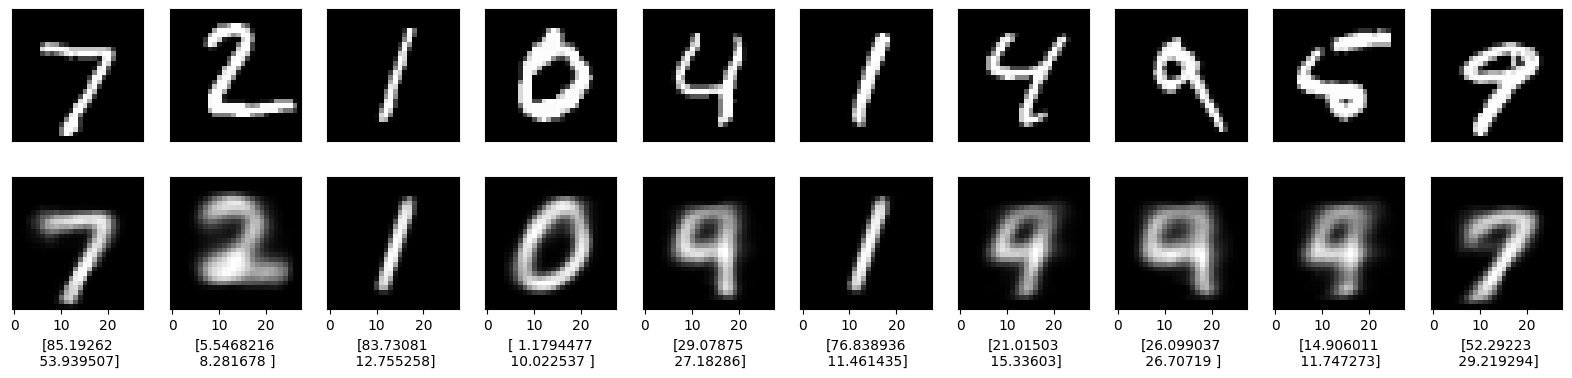

In [16]:
#Show results: original, encode inner latent representation, decoded image
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.set_xlabel("{}".format(np.array2string(encoded_imgs[i],max_line_width=10)))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    ;
plt.show()

By compressing the inner representation to 2 dimensions the generated pictures become "blurry". If you would take a higher latent dimension the autoencoder can generate sharper pictures. In the slide/picture inserted above (introducing the autoencoder), you can compare the results with the different compressions to get an impression. Or you can copy this notebook and try for yourself with different latent dimensions, different encoder/decoder neural network setups, etc.

The advantage of compressing the inner latent representation to 2 dimensions is that you can make that latent representation visible in a scatterplot and showcase that it has structure. The internal representation of the numbers group together, interesting!

79/79 [==============================] - 0s 2ms/step


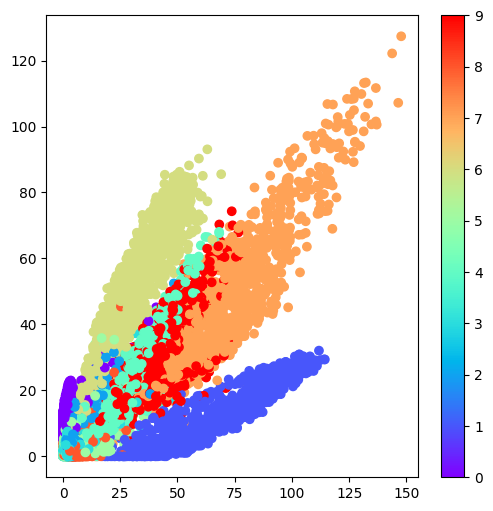

In [17]:
# Showcase the inner hidden/latent space by plotting all the test images on the latent space
x_test_encoded = encoder.predict(x_test, batch_size=128)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=x_test_label, cmap='rainbow')
plt.colorbar()
plt.show()



Note that the figure changes whenever you do a new run, it leads to different latent structures.

We can now also take some latent representation and see what picture is generated. The internal representation + decoder has become a kind of generative model.
If you would copy and run this notebook (top-right) the cell below will give you 2 slide bars to explore the inner latent space and you can see how the picture morphs into the different numbers. Quite fun to experiment with.

interactive(children=(IntSlider(value=150, description='x', max=450, min=-150), IntSlider(value=150, descripti…

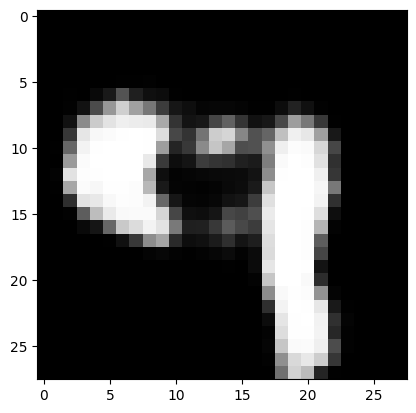

<Figure size 640x480 with 0 Axes>

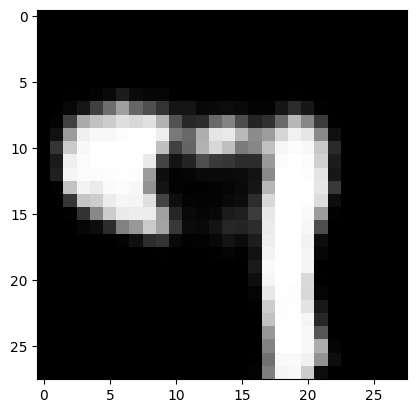

<Figure size 640x480 with 0 Axes>

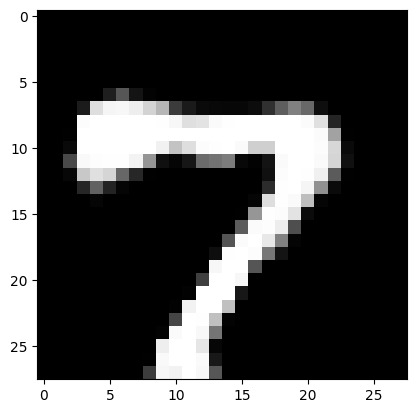

<Figure size 640x480 with 0 Axes>

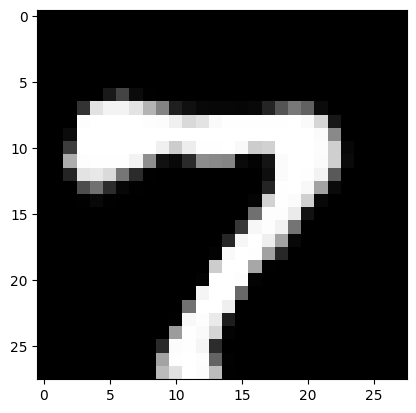

<Figure size 640x480 with 0 Axes>

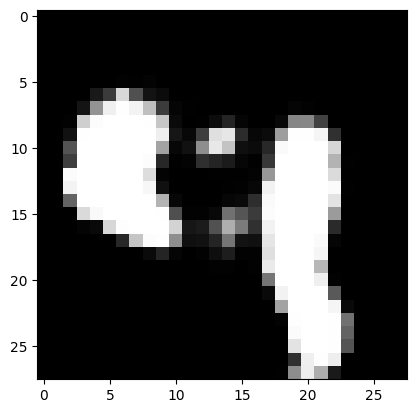

<Figure size 640x480 with 0 Axes>

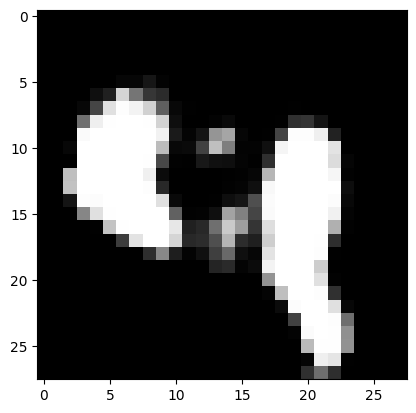

<Figure size 640x480 with 0 Axes>

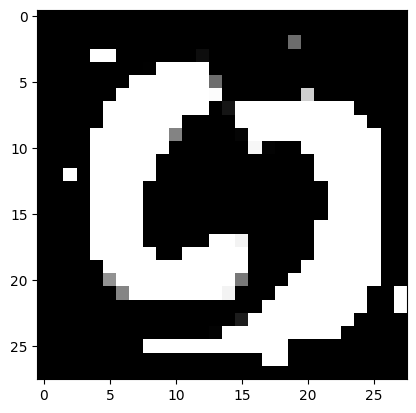

<Figure size 640x480 with 0 Axes>

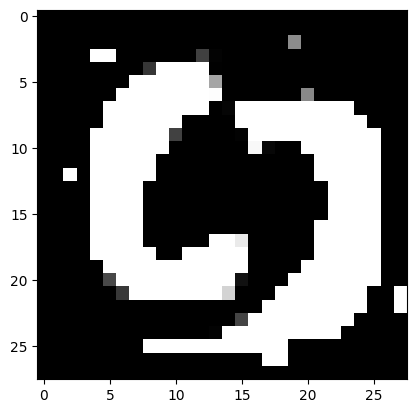

<Figure size 640x480 with 0 Axes>

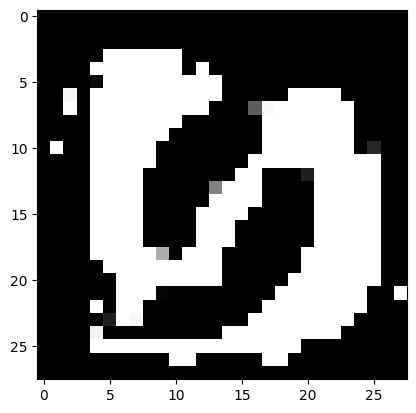

<Figure size 640x480 with 0 Axes>

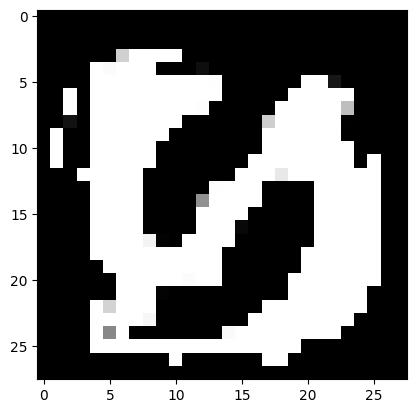

<Figure size 640x480 with 0 Axes>

In [20]:
@interact
def morph(x = 150, y=150):
    x_decoded = decoder.predict(np.array([[x, y]]))
    plt.imshow(x_decoded.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.figure()

<a id='sec2'></a>
# Variational autoencoder
The variational autoencoder extends the capabilities of autoencoder by not only learning the representation of data but also the distribution of data by using variational Bayesian inference. It is a probabilistic autoencoder. Why is that important? Because according to the leading neuroscientific approach, the [Free Energy Principle](https://www.wired.com/story/karl-friston-free-energy-principle-artificial-intelligence/) (FEP) by [Karl Friston](https://www.fil.ion.ucl.ac.uk/~karl/), the brain is a probabilistic prediction mechanism, one that attempts to minimize the error of its hypothesis about the world and the sensory input it receives:

+ The skull-bound brain needs to infer the world.
+ The brain builds an internal probabilistic model of the world using Bayesian inference (the generative model).
+ Discrepancies between the internal model (the prediction) and the sensory observations result in prediction error.
+ The brain aims to minimize the prediction errors by minimizing the Free Energy. It can do so by improving perception, acting on the environment, learning the generative model, etc

The Free energy is equivalent to the negative of the Evidence Lower BOund (ELBO), the loss function of the variational autoencoder. That is why I started this notebook with: the variational autoencoder estimates the latent/hidden states according to the leading neuroscientific approach!

I hope this point got your attention!

Understanding papers published about the free energy has a steep learning curve.  I started a tutorial series on Kaggle which I positioned as [Free Energy Principle tutorial without a PhD](https://www.kaggle.com/charel/learn-by-example-active-inference-in-the-brain-1) and recorded my notes with examples to make it much more accessible.

<img src="https://i.imgur.com/Jt5TANO.jpg" width=800>





## Minimizing the Free Energy or minimizing the negative Evidence Lower BOund (ELBO)

The Free Energy bounds the surprise in the sensory observations (See [Appendix A.1](#secA1))
$$\mathcal{F}(y_{observation},\zeta)= D_{KL}(q_{ \zeta }(x_{hypotheses}\mid  y_{observation})\parallel p(x_{hypotheses}\mid  y_{observation}))-ln(p(y_{observation}))\geq  -ln(p(y_{observation}))$$

Where the Free Energy is defined as:

$$\mathcal{F}(y_{observation},\zeta)= \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses} $$

By minimizing the Free energy you will get:
+ a better approximation of $q_{ \zeta }(x_{hypotheses}\mid  y_{observation})$ for $p(x_{hypotheses}\mid  y_{observation})$, in other words $q_{ \zeta }(x_{hypotheses}\mid  y_{observation})$ becomes a more reliable approximation of the true hidden states (they are called hidden because they are not directly observable, hence they need to be inferenced).
+ a lower surprise in the sensory observations $-ln(p(y_{observation}))$, thus the generative model becomes better generating the predicted sensory observations. In other words, a better internal world model.

The Free energy equals the negative ELBO, as you can see by comparing it with the ELBO definition in this paper [Auto-encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) and corresponding [tutorial](https://arxiv.org/pdf/1906.02691.pdf):
$$\mathcal{ELBO}(y_{observation}; \theta, \phi)= ln(p_{\theta}(y_{observation})) - D_{KL}(q_{ \phi }(x_{hypotheses}\mid  y_{observation})\parallel p_{\theta}(x_{hypotheses}\mid  y_{observation}))$$

where $ \theta$ and $\phi$ are the neural network parameters of the encoder resp decoder.

Minimizing the free energy by a gradient descent, equals maximizing the model evidence by gradient ascent on the ELBO, which equals minimizing the negative ELBO by gradient descent. I hope I didn't confuse everybody by now :-)  
In short, the Free energy (or negative ELBO) is the loss function of the variational autoencoder.

This loss function can be mathematically rewritten (see [appendix A2](#secA2)) as

$$\mathcal{Loss}(y_{observation};\theta, \phi)= \underset{KL-loss, \:divergence\: from \:prior}{\underbrace{D_{KL}(q_{ \phi }( x_{hypotheses}\mid y_{observation} )\parallel p_{\theta}(x_{hypotheses}))}} + \underset{reconstruction \: loss}{\underbrace{-\mathbb{E}_{q_{ \theta }(x_{hypotheses}\mid  y_{observation})} [ln(p_{\theta}  (y_{observation}\mid x_{hypotheses}))]}} $$

which you will often see in machine learning papers. It breaks down into 2 parts.  

A reconstruction loss (second part of the above equation) forcing the decoded samples to match the initial inputs (just like in our previous autoencoder). Maximizing the reconstruction likelihood $\mathbb{E}_{q_{ \theta }(x_{hypotheses}\mid  y_{observation})} [ln(p_{\theta}  (y_{observation}\mid x_{hypotheses})]$ -> minimizing the negative reconstruction likelihood -> minimizing the reconstruction loss of the variational autoencoder.

$$\mathcal{Loss}(y_{observation};\theta, \phi)= \underset{KL-loss, \:divergence\: from \:prior}{\underbrace{D_{KL}(q_{ \phi }( x_{hypotheses}\mid y_{observation} )\parallel p_{\theta}(x_{hypotheses}))}} + \underset{reconstruction \: loss}{\underbrace{binary \: crossentropy \: (input \: image, reconstructed \: image)}} $$

A KL divergence loss (first part of the above equation) between the learned latent distribution and the prior distribution, acting as a regularization term to learn well-formed latent spaces. The probability functions are assumed to be Gaussian/Normal distributions, they can be mathematically efficiently described with just 2 parameters: mean ($\mu$ - the average value of all points) and standard deviation ($\sigma$ - the spread of the points, or can be referred to as $\sigma^2$ - the variance ). Therefor you will find the $\mu$ and $\sigma$ in the latent space of the variational autoencoder. Note that actually a full covariance matrix should be learned to build a true multivariate Gaussian model including covariances between the latent dimensions. However, a simplifying assumption is made that the covariance matrix only has nonzero values on the diagonal, allowing a simple vector in the latent space.

With Gaussian/Normal distributions the KL divergence simplifies to:

$$\mathcal{Loss}(y_{observation};\theta, \phi)= \underset{KL-loss, \:divergence\: from \:prior}{\underbrace{-\frac{1}{2}\sum_j(1+log(\sigma_j^2)-\mu_j^2-\sigma_j^2)}} + \underset{reconstruction \: loss}{\underbrace{binary \: crossentropy \: (input \: image, reconstructed \: image)}} $$

Where j is the dimension of the latent space. This formula you can find back in the code below as the loss function.


## The reparameterization trick

The neural network $\theta$ and $\phi$ parameters can be optimized at the same time using stochastic gradient descent. However, a reparameterization trick is needed to create a differentiable inference model in order to use backpropagation (this cannot be done for a random sampling process). The smart trick is to sample a hidden state x via x = x_mean + x_standard_dev * epsilon, where epsilon is a random normal zero-mean distribution with standard dev 1. Now the random node is not blocking the path for backpropagation for $\mu$ and $\sigma$.

<img src="https://i.imgur.com/Re0AO8z.jpg" width=600>

In this [video](https://youtu.be/rK6bchqeaN8?t=3140) you can find a great explanation of why the reparameterization trick works: "separating the stochastic part from the deterministic parts" and "thus gradient of averages is replaced by taking the gradient and then taking the average, this reduces the variance hugely".  

To summarize it in one slide:


![](https://i.imgur.com/fwua9AB.jpg)

Note: In the free energy Kaggle notebooks I used x as the hidden state and y as the sensory observations, hence I used the same set-up in this notebook. In autoencoder literature is is often custom to use z as the latent space notation. Just a notation thing.



## The variational autoencoder model
Also in this example, I use for the encoder and decoder both plain dense neural networks with both 2 layers. As per variational autoencoder setup, the encoder splits into two parameters in the latent space: the mean and the (log) variance. Followed by the sampling layer based on the reparameterizationn trick. A decoder neural network maps the latent space back to the original input data.

Like in the previous example, the autoencoder is defined as one model, plus separately the encoder model and decoder model, referencing the autoencoder layers (the 3 models share their weights), in order to inspect the inner representation (this part can be omitted in case you don't want to use/show the inner latent representation)

The parameters of the model are trained via the Free Energy loss function: a reconstruction loss part and the KL divergence loss part.


In [21]:
K.clear_session()

In [22]:
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = 784
intermediate_dim = 256
latent_dim = 2 #

In [23]:
# Variational autoencoder model
input_img = tensorflow.keras.Input(shape=(original_dim,))
encoded   = layers.Dense(intermediate_dim,
                         activation='relu'
                         )(input_img)

# Two outputs
x_mean    = layers.Dense(latent_dim)(encoded)
x_log_var = layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation


In [30]:
# Function to take a sample
def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(
                                     K.shape(x_mean)[0],
                                     latent_dim
                                     ),
                              mean=0.,
                              stddev=1.0
                              )

    return x_mean + K.exp(0.5 * x_log_var) * epsilon # (e^a)^b=e^ab


In [31]:
x = tensorflow.keras.layers.Lambda(sampling,
                                   output_shape=(latent_dim,)
                                   )([x_mean, x_log_var])

# at this point the representation has dimension: latent_dim

TypeError: ignored

In [ ]:


decoded = layers.Dense(intermediate_dim, activation='relu')(x)
decoded = layers.Dense(original_dim, activation='sigmoid')(decoded)
vae = keras.Model(input_img, decoded, name='vae')
#print (vae.summary())

# Create the loss function and compile the model
# The loss function as defined by paper Kingma
reconstruction_loss = original_dim * keras.metrics.binary_crossentropy(input_img, decoded)
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation

# encoder model (first part of the variotional autoencoder)
encoder = keras.Model(input_img, [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = vae.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = vae.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
#print (decoder.summary())




/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_5.
  'be expecting any data to be passed to {0}.'.format(name))


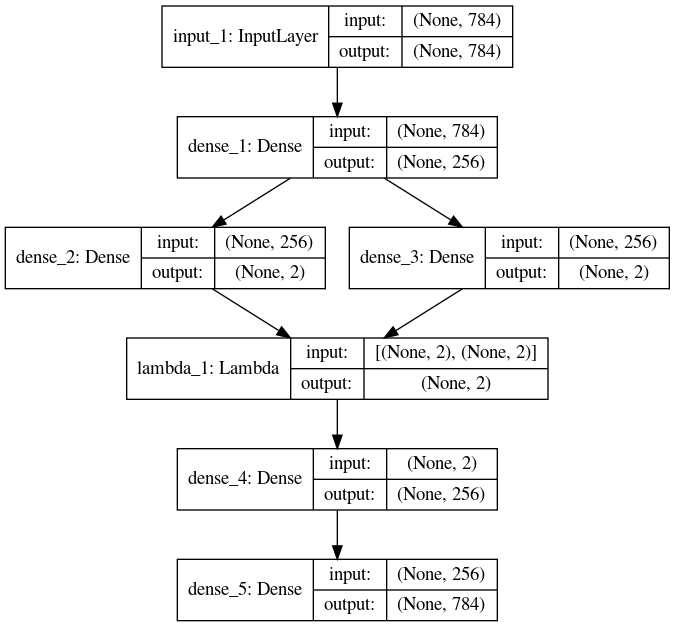

In [ ]:
keras.utils.plot_model(vae, to_file='model.png', show_shapes=True)

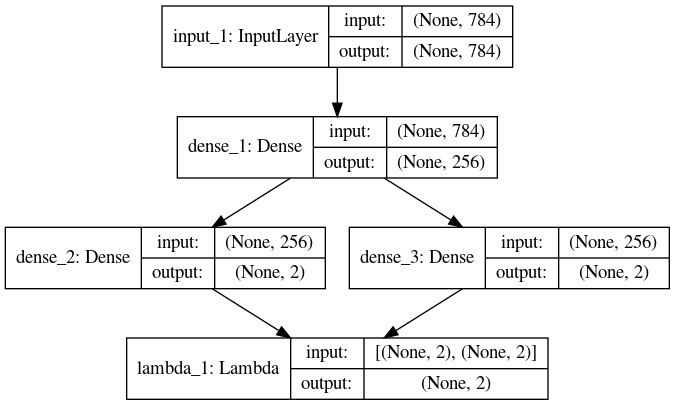

In [ ]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)


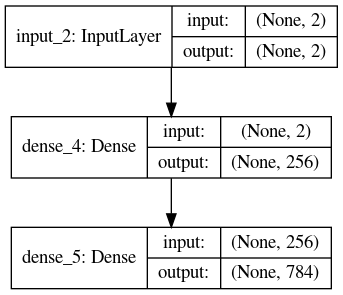

In [ ]:
keras.utils.plot_model(decoder, to_file='model.png', show_shapes=True)

## Training
The variational autoencoder is trained the same way the the regular autoencoder. No need to supply the labels.

In [ ]:
vae.fit(x_train,None,
        shuffle=True,
        epochs=50,
        batch_size=256,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 57us/step - loss: 223.5199 - val_loss: 185.1997
Epoch 2/50
60000/60000 [==============================] - 3s 52us/step - loss: 180.3292 - val_loss: 174.9376
Epoch 3/50
60000/60000 [==============================] - 3s 52us/step - loss: 172.6769 - val_loss: 170.7841
Epoch 4/50
60000/60000 [==============================] - 3s 53us/step - loss: 169.6458 - val_loss: 168.8000
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 167.7298 - val_loss: 167.2577
Epoch 6/50
60000/60000 [==============================] - 3s 56us/step - loss: 166.0626 - val_loss: 165.6151
Epoch 7/50
60000/60000 [==============================] - 3s 53us/step - loss: 164.6451 - val_loss: 164.2845
Epoch 8/50
60000/60000 [==============================] - 3s 53us/step - loss: 163.3931 - val_loss: 163.0851
Epoch 9/50
60000/60000 [==============================] - 3s 52us/step - loss:

## The results

Let's have a look at the result, and especially the latent representation.

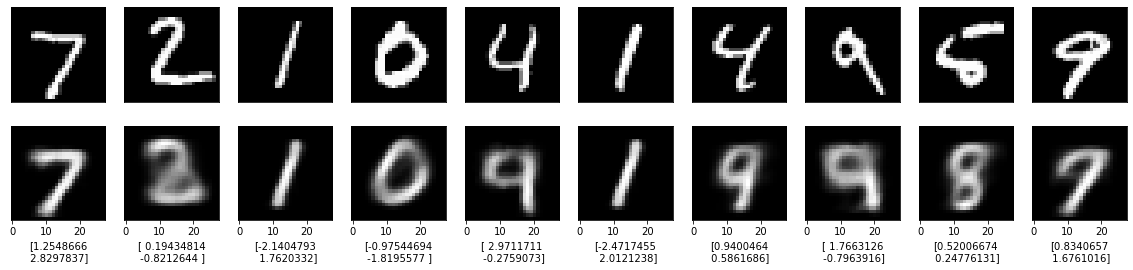

In [ ]:
# Encode and decode some digits, show the inner latent variable, inner representation

encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test)

#Show results: original, encode inner latent representation, decoded image
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.set_xlabel("{}".format(np.array2string(encoded_imgs[i],max_line_width=10)))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    #ax.get_xaxis().set_visible(False)
    ;
plt.show()

By compressing the inner representation to 2 dimensions the generated pictures become "blurry", like this happened with the autoencoder. If you would take a higher latent dimension the variational autoencoder can generate sharper pictures. In the slide/picture inserted above (introducing the variational autoencoder), you can compare the results with the different compressions to get an impression.

And again, the advantage of compressing the inner latent representation to 2 dimensions is that you can make that latent representation visible in a scatterplot and showcase that it has structure. The internal representation of the numbers group tigher together if you compare it to the auoencoder latent space scatterplot (e.g. look at the dimensions of the scatterplot).

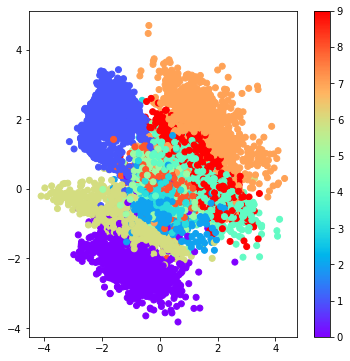

In [ ]:
# Showcase the inner hidden/latent space by plotting all the test images on the latent space
x_test_encoded = encoder.predict(x_test, batch_size=128)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=x_test_label, cmap='rainbow')
plt.colorbar()
plt.show()

And because the latent space is 2 dimensions, we can make the internal probabilistic model of the world (the generative model) nicely visible. The generative model $p(y_{observation} , x_{hypotheses})=p(y_{observation}\mid x_{hypotheses})p(x_{hypotheses}) $ which is the internal representation + decoder.


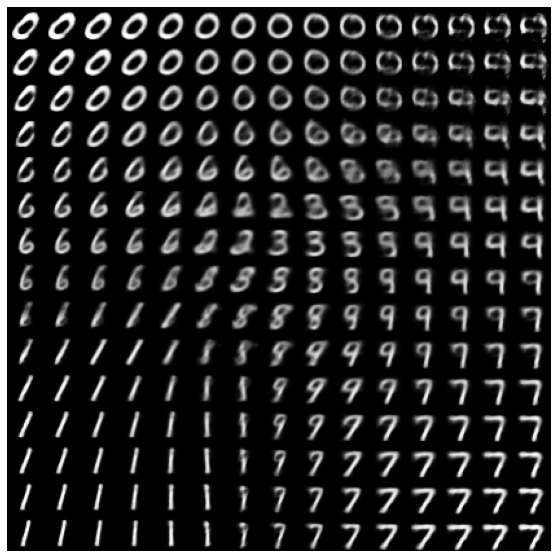

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Ssample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis('off')
plt.show()

If you copy and run this notebook (top-right), the cell below will give you 2 slide bars to explore the inner latent space and you can see how the picture morphs into the different numbers as shown above. Quite fun to experiment with.


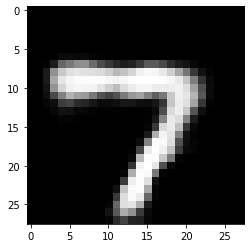

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
@interact

def morph(x = 3, y=3):
    x_decoded = decoder.predict(np.array([[x, y]]))
    plt.imshow(x_decoded.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.figure()

<a id='sec3'></a>
# Disentangled variational autoencoder

One further enhancement to the variational autoencoder was suggested in this [paper](https://openreview.net/pdf?id=Sy2fzU9gl) to get well-formed latent spaces, branded as the disentangled variational autoencoder. It basically boils down to adding an extra weight factor on the KL-loss part of the loss function, to enhance the forming of better-formed latent spaces, even into interpretable factorized latent representations.  
One of their experiments is reproduced below. By generating a data-set of images out of 5 independent latent variables, can the disentangled variational autoencoder reconstruct these latent variables, by learning them from the images? Yes, it can do so (to a certain extend). Interesting! And note the word factorized, it means the generated latent variables discovered by the disentangled variational autoencoder should correspond 1:1 to the original latent spaces used to generate the images.


## Dsprites
The   [Dsprites](https://github.com/deepmind/dsprites-dataset) dataset is a great way to assess the capability of unsupervised learning methods to reconstruct/abstract latent variables. Based on 5 independent variables images are generated, and it is interesting to see if and how a variable auto-encoder can discover these 5 latents variables out of the images. The latent variables used to generate the images:
+ Color: 1 value: white (fixed to 1, hence 5 latent variables and not 6)
+ Shape: 3 values: square, ellipse, heart
+ Scale: 6 values: linearly spaced in [0.5, 1]
+ Orientation: 40 values in [0, 2 pi]
+ Position X: 32 values in [0, 1]
+ Position Y: 32 values in [0, 1]  

The dataset contains 1*3*6*40*32*32=737280 total images, every posible combination once.
The images are: (737280 x 64 x 64, uint8) in black and white.

Example images in the dataset, picture from the dataset github page:  
![](https://github.com/deepmind/dsprites-dataset/blob/master/dsprites.gif?raw=true)

In [ ]:
#Load the dataset and show the meta-data
!git clone https://github.com/deepmind/dsprites-dataset
%cd dsprites-dataset
%ls
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='latin1',allow_pickle=True)
print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']

latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)




Cloning into 'dsprites-dataset'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
/kaggle/working/dsprites-dataset
CONTRIBUTING.md  dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5
LICENSE          dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz
README.md        dsprites_reloading_example.ipynb
dsprites.gif
Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7fdc8ab88290>)
Metadata: 
 {'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_nam

In [ ]:
# Create the training and test data set, code re-used from: https://github.com/deepmind/dsprites-dataset
latents_sizes = metadata['latents_sizes']
print(latents_sizes)
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

# Sample the training set (60000)
x_train_latents = sample_latent(size=60000)
x_train_indices = latent_to_index(x_train_latents)
x_train = imgs[x_train_indices]

# Sample the test set (5000)
x_test_latents = sample_latent(size=5000)
x_test_indices = latent_to_index(x_test_latents)
x_test = imgs[x_test_indices]

[ 1  3  6 40 32 32]


(60000, 64, 64)


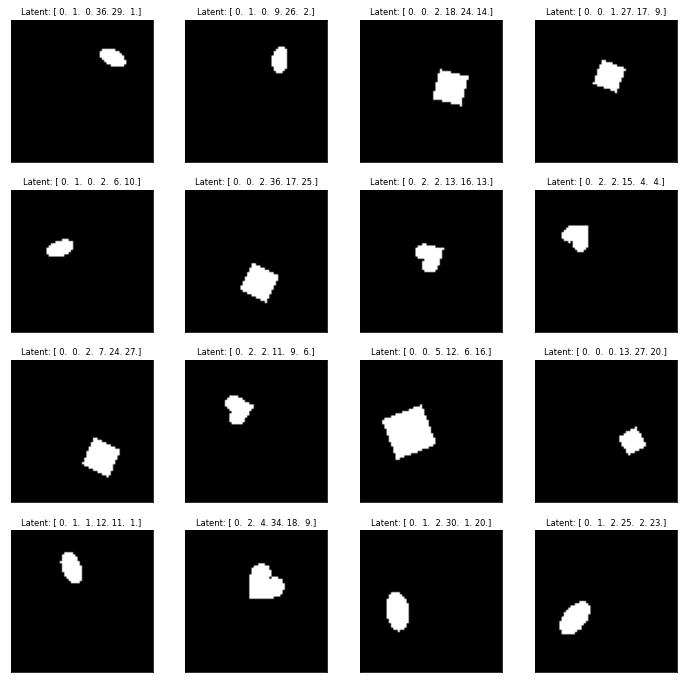

In [ ]:
print(x_train.shape)
nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(nrows * 3, ncols *3))
for row in range(nrows):
    for col in range(ncols):
        rand_example = np.random.choice(len(x_train))
        ax[row,col].imshow(x_train[rand_example],cmap='gray')
        ax[row,col].set_title("Latent: {}".format(x_train_latents[rand_example]),fontsize='small')
        #ax[row,col].axis('off')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

In [ ]:
# Showcase the latent/hidden state format, the values used to generate the image
print(x_train_latents.shape)
print('Training image nr 2 latent space: ', x_train_latents[2])
print("('color', 'shape', 'scale', 'orientation', 'posX', 'posY')")
print(x_test_latents.shape)
print('Test image nr 2 latent space: ',x_test_latents[2])


(60000, 6)
Training image nr 2 latent space:  [ 0.  2.  0.  6. 29.  8.]
('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
(5000, 6)
Test image nr 2 latent space:  [ 0.  0.  4. 32.  0. 23.]


In the experiment in the paper flattened 32x32 images are used, so reshaping the 64x64 images to reconstruct the experiment

In [ ]:
# I will use a plain dense neural network in the variational autoencoder, so need to reshape 64*64 images into 1024 flat
import tensorflow as tf
print('shape ', x_train.shape)
x_train = np.expand_dims(x_train, axis=-1)
print('shape ', x_train.shape)
x_train = tf.image.resize(x_train, [32,32]) # resize
print('shape ', x_train.shape)
x_train = np.squeeze(x_train, axis=-1)
print('shape ', x_train.shape)
x_train = x_train.reshape([len(x_train), 32*32])
print('shape ', x_train.shape)
print('length ', len(x_train))
# No need to normalize the data of the images, pixels are on (1) or off (0)

#x_test = x_test.reshape([len(x_test), 64*64])
x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32,32]) # resize
x_test = np.squeeze(x_test, axis=-1)
x_test = x_test.reshape([len(x_test), 32*32])

shape  (60000, 64, 64)
shape  (60000, 64, 64, 1)
shape  (60000, 32, 32, 1)
shape  (60000, 32, 32)
shape  (60000, 1024)
length  60000


(60000, 1024)


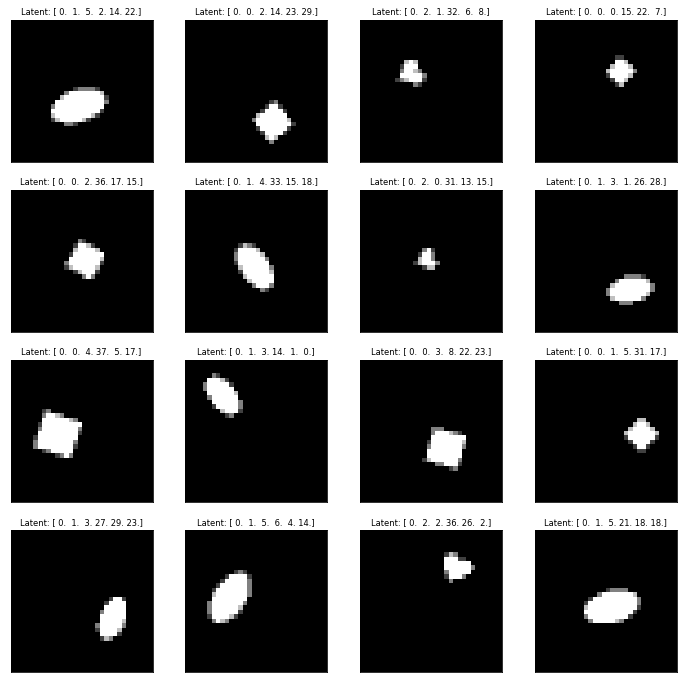

In [ ]:
#Quick check the reshaped images still look good
print(x_train.shape)
nrows = 4
ncols = 4
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(nrows * 3, ncols *3))
for row in range(nrows):
    for col in range(ncols):
        rand_example = np.random.choice(len(x_train))
        #ax[row,col].imshow(x_train[rand_example],cmap='gray')
        ax[row,col].imshow(x_train[rand_example].reshape(32, 32),cmap='gray')
        ax[row,col].set_title("Latent: {}".format(x_train_latents[rand_example]),fontsize='small')
        #ax[row,col].axis('off')
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])

Verify the labels are distributed evenly

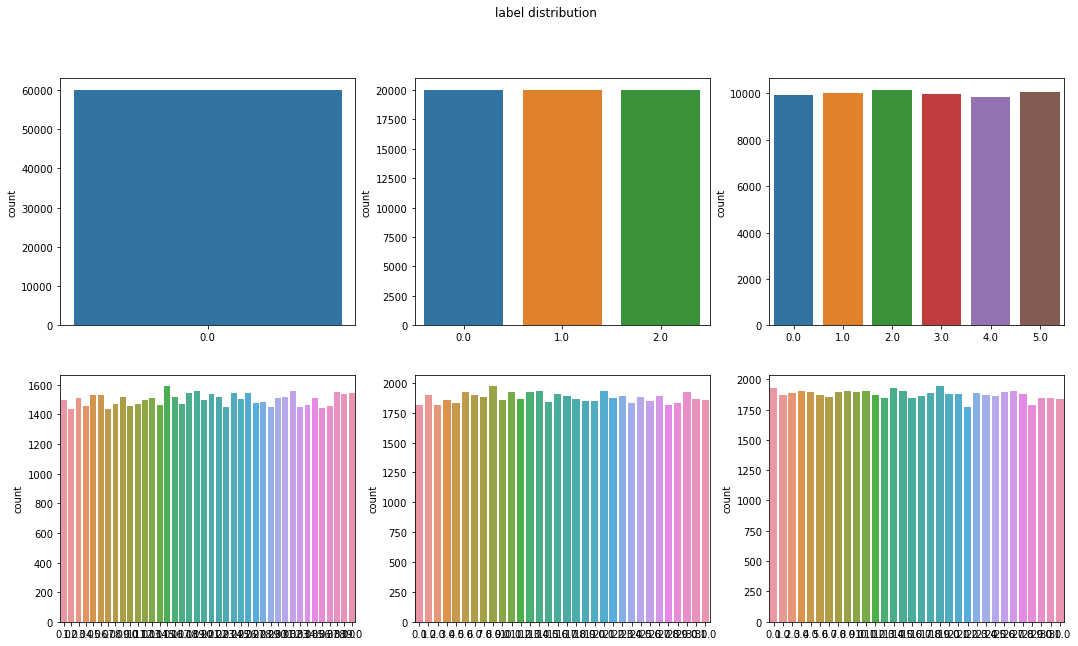

In [ ]:
# verify the labels are distributed evenly

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('label distribution')
sns.countplot(x_train_latents[:,0],ax=axes[0, 0])
sns.countplot(x_train_latents[:,1],ax=axes[0, 1])
sns.countplot(x_train_latents[:,2],ax=axes[0, 2])
sns.countplot(x_train_latents[:,3],ax=axes[1, 0])
sns.countplot(x_train_latents[:,4],ax=axes[1, 1])
sns.countplot(x_train_latents[:,5],ax=axes[1, 2])

## The disentangled variational autoencoder model

The same code/model as the variational autoencoder model, except the Beta weighting factor is set to 4 and the encoder/decoder neural networks have an additional fully connected layer, the same as in the experiment described in the paper.

In [ ]:
K.clear_session()

# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = 1024
intermediate_dim = 1200
latent_dim = 8 #

# Variational autoencoder model
input_img = keras.Input(shape=(original_dim,))
encoded = layers.Dense(intermediate_dim, activation='relu')(input_img)
encoded = layers.Dense(intermediate_dim, activation='relu')(encoded)
x_mean = layers.Dense(latent_dim)(encoded)
x_log_var = layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5*x_log_var)*eps
    x_mean, x_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon # (e^a)^b=e^ab
x = layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
# at this point the representation has dimension: latent_dim

decoded = layers.Dense(intermediate_dim, activation='tanh')(x)
decoded = layers.Dense(intermediate_dim, activation='tanh')(decoded)
decoded = layers.Dense(original_dim, activation='sigmoid')(decoded)
vae = keras.Model(input_img, decoded, name='vae')
print (vae.summary())

# Create the loss function and compile the model
# The loss function as defined by paper Kingma
reconstruction_loss = original_dim * keras.metrics.binary_crossentropy(input_img, decoded)
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
beta = 4 # disentangled variational autoencoder <---------------------------------------------
vae_loss = K.mean(reconstruction_loss + beta*kl_loss)
vae.add_loss(vae_loss)
opt = keras.optimizers.Adam(learning_rate=0.01)
vae.compile(optimizer=opt)

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation

# encoder model (first part of the variational autoencoder)
encoder = keras.Model(input_img, [x_mean, x_log_var, x], name='encoder')
print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = vae.layers[-3](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = vae.layers[-2](decoder_layer)
decoder_layer = vae.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
print (decoder.summary())


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1200)         1230000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1200)         1441200     dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8)            9608        dense_2[0][0]                    
________________________________________________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_7.
  'be expecting any data to be passed to {0}.'.format(name))


## Training
The disentangled variational autoencoder is trained the same way the the (variational) autoencoder. No need to supply the labels.

In [ ]:
vae.fit(x_train,None,
        shuffle=True,
        epochs=15,
        batch_size=256,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 5000 samples
Epoch 1/15
60000/60000 [==============================] - 24s 398us/step - loss: 142.9197 - val_loss: 75.4819
Epoch 2/15
60000/60000 [==============================] - 25s 414us/step - loss: 68.6369 - val_loss: 66.3759
Epoch 3/15
60000/60000 [==============================] - 24s 407us/step - loss: 65.9766 - val_loss: 66.4258
Epoch 4/15
60000/60000 [==============================] - 23s 389us/step - loss: 66.2297 - val_loss: 69.1423
Epoch 5/15
60000/60000 [==============================] - 25s 412us/step - loss: 67.1215 - val_loss: 69.5133
Epoch 6/15
60000/60000 [==============================] - 25s 409us/step - loss: 67.0890 - val_loss: 68.5548
Epoch 7/15
60000/60000 [==============================] - 24s 404us/step - loss: 66.9408 - val_loss: 68.9064
Epoch 8/15
60000/60000 [==============================] - 24s 395us/step - loss: 67.0310 - val_loss: 69.1633
Epoch 9/15
60000/60000 [==============================] - 25s 411us/step - los

## The results

Let's have a look at the result, and especially the latent representation.

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


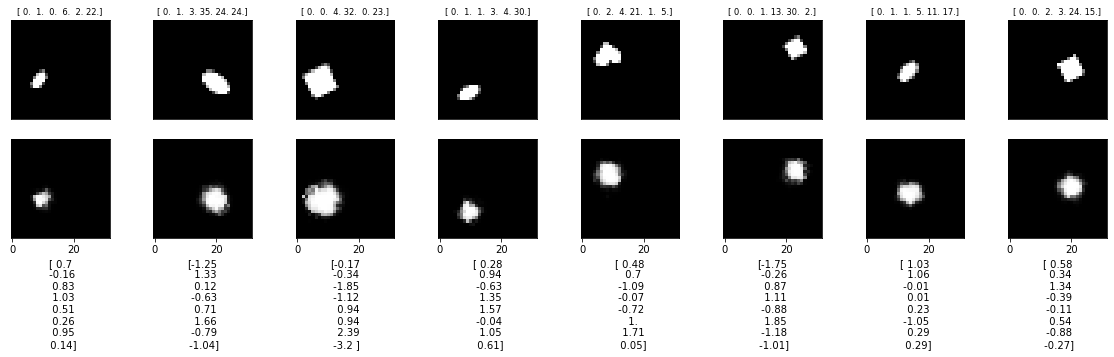

In [ ]:
# Encode and decode some digits, show the inner latent variable, inner representation

encoded_imgs = encoder.predict(x_test)[2]
decoded_imgs = decoder.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test)

#Show results: original, encode inner latent representation, decoded image
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)
n = 8 # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32),cmap='gray')
    ax.set_title(x_test_latents[i],fontsize='small')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    latent = encoded_imgs[i,0]+encoded_imgs[i,1]
    plt.imshow(decoded_imgs[i].reshape(32, 32),cmap='gray')
    ax.set_xlabel("{}".format(np.array2string(encoded_imgs[i],max_line_width=10)))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    ;
plt.show()

Below, again, you'll find the code to interact with the results. The effect I hoped to see is that certain latent variables of the autoencoder start to correspond one-to-one with the hidden states of the original data. That is, one latent variable corresponds with the horizontal position, vertical position, the size, orientation, or the type of image.

Please use the interaction below (copy-paste the notebook and run the cell) to find out for yourself. In my trials, I saw that
+ 1 of the latent variables was clearly corresponding to seize
+ 2 latent variables to the position (it was not a straight forward x and y correlation, but more 2 half arcs)
+ 1 or 2 latent variables did something with the shape (but the shapes were blurry, so I could not conclude if it was trying to get the shape or orientation right).  

I can conclude I saw a some form of correlation between the factors that generated the data sets and the latent variables, interesting!

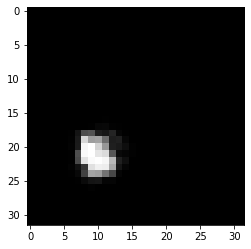

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
@interact

def morph(x0 = 1, x1=1, x2 = 1, x3=1,x4 = 1, x5=1, x6 = 1, x7=1):
    x_decoded = decoder.predict(np.array([[x0, x1,x2, x3,x4, x5,x6, x7]]))
    plt.imshow(x_decoded.reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.figure()

<a id='secA'></a>
# Appendix

<a id='secA1'></a>
## The Free Energy bounds the surprise in the sensory observations

Below you will find a short math overview how the Free Energy bounds the surprise in sensory observations. For an extensive overview including the explanations, please visit the [Free Energy Principle tutorial without a PhD](https://www.kaggle.com/charel/learn-by-example-active-inference-in-the-brain-1) tutorial series.

### Bayesian inference

Let's define:  
*  $p(x_{hypotheses})$ as the probability density of hypotheses x.
*  $p(x_{hypotheses}\mid  y_{observation})$ as the probability density of hypotheses x  given the observation y (conditional probability)
*  $p(x_{hypotheses}, y_{observation})$ as the probability density of hypotheses x and observation y together (joint probability)  

Bayes' theorem can be derived from basic probability rules:

Symmetric property:
$$p(y_{observation} , x_{hypotheses})=p(x_{hypotheses},  y_{observation})$$  
Apply the product rule:
$$p(x_{hypotheses}\mid  y_{observation})p(y_{observation})=p(y_{observation}\mid x_{hypotheses})p(x_{hypotheses})$$
Which leads to Bayes' theorem:  
$$p(x_{hypotheses}\mid  y_{observation})=\frac{p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})}{p(y_{observation})} $$  

### Variational Bayesian Inference

Unfortunately, we do have a challenge calculating the denominator $p(y_{observation})$ of Bayes' theorem. It can be easily seen by writing out (applying the sum rule, the probability of x equals the probability of the sum of the probability of x given y for all possible y) the denominator leading to equation [2a] for discrete variables or equation [2b] for continues variables:  
$$p(x_{hypotheses}\mid  y_{observation})=\frac{p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})}{\sum_xp(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})} \:\:\:\:\:   [2a]$$
$$p(x_{hypotheses}\mid  y_{observation})=\frac{p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})}{\int p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})dx} \:\:\:\:\:   [2b]$$

The denominator normalizes the probability, in other words, you need to average over all possible occurrences of the sensory observations (how to even know all possible observations?). The part in the nominator: $p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})$ is just one of the cases of the denominator as is easily seen in the discrete equation. Let alone calculating an integral $\int p(y_{observation}\mid  x_{hypotheses}) * p(x_{hypotheses})dx$ for continues variables. Which is unavailable in a complex high dimensional real world, or requires exponential time to compute! In short, the denominator $p(y_{observation})$ is generally intractable.  

The solution in active inference is to invoke Variational Bayesian inference methods: a set of techniques to *approximate* the posterior  $p(x_{hypotheses}\mid  y_{observation})$ probability density. Find a “recognition” probability density $q_{ \zeta }(x_{hypotheses}\mid  y_{observation})$ that approximates the target density $p(x_{hypotheses}\mid  y_{observation})$.
* From a family of “nice” probability densities, e.g. a Gaussian probability density.
* Is specified by its sufficient statistics $\zeta$ (e.g. for a Gaussian density: mean $\mu$ and variance $\sigma^2$)
* Find the right $\zeta$ such that $q_{ \zeta }(x_{hypotheses}\mid  y_{observation})$ is an approximation for $p(x_{hypotheses}\mid  y_{observation})$, this can be done by minimizing the Free Energy (is equivalent to maximizing the ELBO).


### The Free Energy or negative Evidence Lower BOund (ELBO)

The [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) measures the difference between probability densities. This [video](https://www.youtube.com/watch?v=ErfnhcEV1O8) gives an introduction to KL-Divergence.

For the brain making an internal model of the world $q_{\zeta}(x_{hypotheses}\mid  y_{observation})$ to approximate posterior  $p(x_{hypotheses}\mid  y_{observation})$ probability density it needs to minimize KL with respect to the sufficient statistics $\zeta$ (e.g. for a Gaussian density: mean $\mu$, variance $\sigma^2$)

$$\underset{\zeta }{Argmin}\:  D_{KL}(q_{ \zeta }(x_{hypotheses}\mid  y_{observation})\parallel p(x_{hypotheses}\mid  y_{observation}))$$

The Kullback-Leiber is defined as:

$$D_{KL}(q_{ \zeta }(x_{hypotheses}\mid  y_{observation})\parallel p(x_{hypotheses}\mid  y_{observation})) = \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses}\mid  y_{observation})})dx_{hypotheses}$$

since $p(x,y)=p(x \mid y)p(y)$  
$$=\int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{p(y_{observation})q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses}$$  
since ln(ab)=ln(a)+ln(b)  
$$= \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses} + \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(p(y_{observation}))dx_{hypotheses} $$
since there is no $x_{hypotheses}$ in $p(y_{observation})$  
$$= \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses} + ln(p(y_{observation}))\int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})dx_{hypotheses} $$
since the integral over a probability density function equals one
$$= \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses} + ln(p(y_{observation}))$$  
since ln(a/b)=-ln(b/a)
$$= -\int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{p(x_{hypotheses},  y_{observation})}{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})})dx_{hypotheses} + ln(p(y_{observation}))$$

The Free Energy is defined as:

$$\mathcal{F}(y_{observation},\zeta)= \int q_{ \zeta }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \zeta }(x_{hypotheses}\mid  y_{observation})}{p(x_{hypotheses},  y_{observation})})dx_{hypotheses} $$

Hence we have that
$$\mathcal{F}(y_{observation},\zeta)= D_{KL}(q_{ \zeta }(x_{hypotheses}\mid  y_{observation})\parallel p(x_{hypotheses}\mid  y_{observation}))-ln(p(y_{observation}))$$

And since the KL-Divergence $\geq $ 0 it follows that the Free Energy bounds the surprise in sensory observations:
$$\mathcal{F}(y_{observation},\zeta) \geq  - ln(p(y_{observation}))$$

where surprise is defined in information theory as $- ln(p(y))$

<img src="https://i.imgur.com/V2eX3F2.jpg" width=800>

<a id='secA2'></a>
## From Free Energy to the VAE loss function

The Free Energy is defined as:

$$\mathcal{F}(y_{observation}; \theta, \phi)= \int q_{ \phi  }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \phi  }(x_{hypotheses}\mid  y_{observation})}{p_{\theta}(x_{hypotheses},  y_{observation})})dx_{hypotheses} $$

$$= \int q_{ \phi  }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \phi  }(x_{hypotheses}\mid  y_{observation})}{p_{\theta}(x_{hypotheses})p_{\theta}( y_{observation} \mid x_{hypotheses} )})dx_{hypotheses} $$

$$= \int q_{ \phi  }(x_{hypotheses}\mid  y_{observation})[ln(\frac{q_{ \phi  }(x_{hypotheses}\mid  y_{observation})}{p_{\theta}(x_{hypotheses})})-ln(p_{\theta}( y_{observation} \mid x_{hypotheses} ))]dx_{hypotheses}$$

$$= \int q_{ \phi  }(x_{hypotheses}\mid  y_{observation})ln(\frac{q_{ \phi  }(x_{hypotheses}\mid  y_{observation})}{p_{\theta}(x_{hypotheses})})dx_{hypotheses} - \int q_{ \phi  }(x_{hypotheses}\mid  y_{observation}) ln(p_{\theta}( y_{observation} \mid x_{hypotheses} ))dx_{hypotheses}$$

$$= \underset{KL-loss, \:divergence\: from \:prior}{\underbrace{D_{KL}(q_{ \phi }( x_{hypotheses}\mid y_{observation} )\parallel p_{\theta}(x_{hypotheses}))}} - \underset{reconstruction \: loss}{\underbrace{\mathbb{E}_{q_{ \theta }(x_{hypotheses}\mid  y_{observation})} [ln(p_{\theta}  (y_{observation}\mid x_{hypotheses}))]}} $$

$$=\mathcal{Loss}(y_{observation};\theta, \phi)$$